<a href="https://colab.research.google.com/github/TALeonard/19ma573thomasleonard/blob/master/src/MA573_Project_Larger_Scale_IV_Calculation_v02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We are going to attempt to compute implied volatilities for the system. Import numpy, scipy.stats and pyplot for the sake of use, and clone in the proper files from my directory.

In [2]:
#!git clone https://github.com/TALeonard/19ma573thomasleonard.git #Only run once!

Cloning into '19ma573thomasleonard'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 413 (delta 45), reused 0 (delta 0), pack-reused 286
Receiving objects: 100% (413/413), 1.50 MiB | 20.23 MiB/s, done.
Resolving deltas: 100% (147/147), done.


In [1]:
cd /content/19ma573thomasleonard/src/

/content/19ma573thomasleonard/src


In [0]:
import numpy as np
import scipy.optimize as so
import matplotlib.pyplot as plt
import pandas as pd
from european_options_class import VanillaOption
from gbm_1d_class_v02 import Gbm

Define the "default" parameters which are true for every asset. These include:

* Otype - this is 1 for all values (I am only looking at calls for parsimony)
* Maturity - dependant on which fileset I am using. For the 4/18/2019 set, this maturty is 21 days out (I acquired this data on 3-27-2019). This doesn't count the day itself, and I will only count business days, so this is  actually 16 days (or 16/252, to convert to years).
* Interest rate - again, dependent on fileset. For 4/18/2019, r = 2.45%.

For the other data, we have the remaining information - Spot price, strike price, and (for implied volatility computation) the Option Price.

In [0]:
r = 0.0245
otype = 1
maturity = 16/252

Import the data. Each dataset is separated by maturity date.

In [0]:
df = pd.read_csv('calls_4_18_2019.csv')

stock_names = df.Stock
spot_prices = df['Stock Price']
strikes = df.Strike
true_prices = df['Option Price']
true_iv = df.IV

In [6]:
stock_names[89]

'VZ'

From this, we now have a set of variables which represent lists of each piece of worthwhile information from the array - the names of the underlying stocks (for reference), the spot prices used, the strikes, the observed options prices, and the related computed implied volatilities.

Now, build the list of GBMs and the list of options for use.

In [0]:
num_row = stock_names.shape[0]
gbm_list = []
option_list = []
num_data_per_stock = [] # A vector to track how many data points each GBM corresponds to
first_line = True
count = 1

for i in range(num_row):
  option1 = VanillaOption(otype = otype, strike = strikes[i],
                         maturity = maturity, market_price = true_prices[i])
  
  option_list.append(option1)
  if first_line == True:
    gbm1 = Gbm(init_state = spot_prices[i],
            drift_ratio = r,
            vol_ratio = .1 #Initial Guess
            ) 
    gbm_list.append(gbm1)
    first_line = False
  elif stock_names[i] != stock_names[i-1]:
    gbm1 = Gbm(init_state = spot_prices[i],
            drift_ratio = r,
            vol_ratio = .1 #Initial Guess
            ) 
    gbm_list.append(gbm1)
    num_data_per_stock.append(count)
    count = 1
  else:
    count = count + 1
    continue

# Append the count value for the final set in the data, which does not get added if the
# last element in the set isn't uniqueas it does not trigger the elif condition 
# regardless of whether the last element is unique or part of a set. If unique, the
# Last element in this array should be 1; otherwise, it is the most updated count.
# In either case, this is the `count` variable.
num_data_per_stock.append(count) 
  

At this point, we now have a set of GBMs which are indexed based on the underlying stock name. My goal is producing a code which can take in a mixed bag of option data (organized by underlying, but all in one "group" as it were) and output properly analyzed volatilties for each.

For the purpose of having SOME form of insightful analysis in my final paper, I will opt to consider all 3 error functions defined in class, so that I can compare the outputs of each:

* $H(x,y) = (\sum_{i = 1}^{n} |x_{i} - y_{i}|^{2})^{1/2}$
* $H(x, y) = (\sum_{i =1}^{n} |\frac{x_{i} - y_{i}}{y_{i}}|^{2})^{1/2}$ 
* $H(x,y) = (\sum_{i=1}^{n}|\ln(x_{i}) - \ln(y_{i})|^{2})^{1/2}$

Note: These had weight variables in lecture, which allowed for varying weights on each option, and varying exponents. I am opting to use $p = 2$ and $w_{i} = 1$ in all cases, for parity. In each case, I will be minimizing the error of the argument under the square root, as it will be positive (which means minimizing it will minimize my overall error regardless of root, since my root is positive).

In [0]:
'''==========
Define the error function methods
=========='''

def error_function_abs(vol, gbm_list, option_list, num_data_per_set):
  ndps = num_data_per_set
  
  #Initialize conditions that change in the loop.
  ndps_step = 0
  count = 1
  temp_gbm = gbm_list[0]
  temp_gbm.vol_ratio = vol
  
  err1 = 0
  for i in range(len(option_list)):
    err1 = err1 + ((option_list[i]).market_price - gbm.bsm_price(option_list[i]))**2
    # Check if current element of option list is last for this GBM.
    if count == ndps[ndps_step]:
      ndps_step = ndps_step + 1
      temp_gbm = gbm_list[ndps_step]
      count = 1
    if count != ndps[ndps_step]:
      count = count + 1
  return err1

In [0]:
def error_function_ssre(vol, gbm_list, option_list, num_data_per_set):
  ndps = num_data_per_set
  
  #Initialize conditions that change in the loop.
  ndps_step = 0
  count = 1
  temp_gbm = gbm_list[0]
  temp_gbm.vol_ratio = vol
  
  err1 = 0
  for i in range(len(option_list)):
    err1 = err1 + (((option_list[i]).market_price - gbm.bsm_price(option_list[i]))/gbm.bsm_price(option_list[i]))**2
    # Check if current element of option list is last for this GBM.
    if count == ndps[ndps_step]:
      ndps_step = ndps_step + 1
      temp_gbm = gbm_list[ndps_step]
      count = 1
    if count != ndps[ndps_step]:
      count = count + 1
  return err1

In [0]:
def error_function_ln(vol, gbm_list, option_list, num_data_per_set):
  ndps = num_data_per_set
  
  #Initialize conditions that change in the loop.
  ndps_step = 0
  count = 1
  temp_gbm = gbm_list[0]
  temp_gbm.vol_ratio = vol
  
  err1 = 0
  for i in range(len(option_list)):
    err1 = err1 + (np.log((option_list[i]).market_price) - np.log(temp_gbm.bsm_price(option_list[i])))**2
    # Check if current element of option list is last for this GBM.
    if count == ndps[ndps_step]:
      ndps_step = ndps_step + 1
      temp_gbm = gbm_list[ndps_step]
      count = 1
    if count != ndps[ndps_step]:
      count = count + 1
  return err1

In [0]:
'''===========
Define the Calibrated Volatility Seeking methods
==========='''

def bsm_calibration_data_set_abs(gbm_list,option_list,num_stock_per_set):
  nsps = num_stock_per_set #Simplify name within code body for easier typing.
  init_vol = .1 #Initial Guess
  return so.fmin(error_function_abs, init_vol, args = (gbm_list, option_list, nsps), disp = 0)[0]

def bsm_calibration_data_set_ssre(gbm_list,option_list,num_stock_per_set):
  nsps = num_stock_per_set #Simplify name within code body for easier typing.
  init_vol = .1 #Initial Guess
  return so.fmin(error_function_ssre, init_vol, args = (gbm_list, option_list, nsps), disp = 0)[0]

def bsm_calibration_data_set_ln(gbm_list,option_list,num_stock_per_set):
  nsps = num_stock_per_set #Simplify name within code body for easier typing.
  init_vol = .1 #Initial Guess
  return so.fmin(error_function_ln, init_vol, args = (gbm_list, option_list, nsps), disp = 0)[0]

In [0]:
'''=============
This isn't used in the final result; it's just a way to compute multiple IVs from a subset of data.
============='''

def bsm_calibration_data_sub_set_abs(gbm_list,option_list,num_stock_per_set):
  nsps = num_stock_per_set #Simplify name within code body for easier typing.
  num_opts = len(option_list)
  num_gbms = len(gbm_list)
  init_vol = .1 #Initial Guess
  
  # Create empty matrices for IVs.
  iv_abs = np.zeros(num_gbms)
  
  # Create empty matrix for temp storage of Options.
  temp_opt_list = []
  
  nsps_step = 0
  count = 1
  
  for i in range(num_opts):
    temp_opt_list.append(option_list[i])
    if count == nsps[nsps_step]:
      iv_abs[nsps_step] = so.fmin(error_function_abs, init_vol,
                                 args = (gbm_list[nsps_step], temp_opt_list),
                                 disp = 0)[0]
      temp_opt_list = []
      nsps_step = nsps_step + 1
      count = 1
    if count != nsps[nsps_step]:
      count = count + 1
  return iv_abs

Now we have the code ready to calibrate to whatever set we want. We can take subsets of the original data (or manipulate the original Pandas dataframe) to do any analysis we want.

Process from here:

1. Take a given data set (start with set as a whole) and compute the calibrated volatility by the 3 methods.
* Use the volatilities to price ALL options within the system.
* Compare prices computed by calibration to true prices of each option with graphs. (Code will be iterative, like error computations, plotting multiple figures)
* Identify subsets to work with (i.e. large asset/small asset, similar bloomberg IVs, etc.)
* Repeat steps 1-3 for each subset.

Additional possible work:

* Sanitize data for other terms besides 21-day option, repeat 1-5.
* Extract exotic options from Bloomberg, price using engine. Have I done a calibration on exotic options before?
  * Seems that OVX and OVXT are the codes to use to get to the exotic engine.
  * How many? Maybe 5? Decide tomorrow; will depend on effort required.

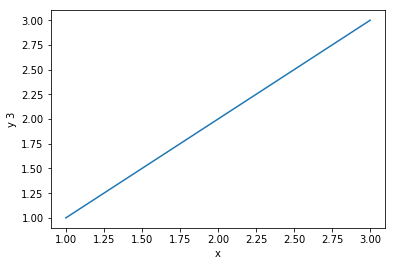

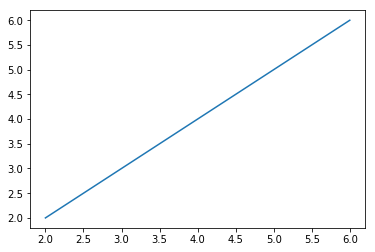

In [61]:
x = [1, 2, 3]
y = [1, 2, 3]
w = [2, 4, 6]
z = [2, 4, 6]

plt.figure()
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("y " + str(y[2]))
plt.figure()
plt.plot(w, z)